In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans

import scipy
from sklearn.neighbors import KernelDensity
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
df = pd.read_csv('data.csv')
df_by_artist = pd.read_csv('data_by_artist.csv')
df_by_genres = pd.read_csv('data_by_genres.csv')
df_by_year = pd.read_csv('data_by_year.csv')
df_w_genres = pd.read_csv('data_w_genres.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

# Complete song data available on spotify

In [ ]:
numeric_cols = df.select_dtypes(include=np.number).columns
non_numeric_cols = df.select_dtypes(exclude=np.number).columns

new_order = ['name', 'artists']
new_order.extend([col for col in non_numeric_cols if col not in new_order])
new_order.extend(numeric_cols)

df = df[new_order]
df = df.drop('id', axis=1)
df

,name,artists,release_date,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
0,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...","['Sergei Rachmaninoff', 'James Levine', 'Berli...",1921,0.0594,1921,0.98200,0.279,831667,0.211,0,0.878000,10,0.6650,-20.096,1,4,0.0366,80.954
1,Clancy Lowered the Boom,['Dennis Day'],1921,0.9630,1921,0.73200,0.819,180533,0.341,0,0.000000,7,0.1600,-12.441,1,5,0.4150,60.936
2,Gati Bali,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,1921,0.0394,1921,0.96100,0.328,500062,0.166,0,0.913000,3,0.1010,-14.850,1,5,0.0339,110.339
3,Danny Boy,['Frank Parker'],1921,0.1650,1921,0.96700,0.275,210000,0.309,0,0.000028,5,0.3810,-9.316,1,3,0.0354,100.109
4,When Irish Eyes Are Smiling,['Phil Regan'],1921,0.2530,1921,0.95700,0.418,166693,0.193,0,0.000002,3,0.2290,-10.096,1,2,0.0380,101.665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170648,China,"['Anuel AA', 'Daddy Yankee', 'KAROL G', 'Ozuna...",2020-05-29,0.6080,2020,0.08460,0.786,301714,0.808,0,0.000289,7,0.0822,-3.702,1,72,0.0881,105.029
170649,Halloweenie III: Seven Days,['Ashnikko'],2020-10-23,0.7340,2020,0.20600,0.717,150654,0.753,0,0.000000,7,0.1010,-6.020,1,68,0.0605,137.936
170650,AYA,['MAMAMOO'],2020-11-03,0.6370,2020,0.10100,0.634,211280,0.858,0,0.000009,4,0.2580,-2.226,0,76,0.0809,91.688
170651,Darkness,['Eminem'],2020-01-17,0.1950,2020,0.00998,0.671,337147,0.623,1,0.000008,2,0.6430,-7.161,1,70,0.3080,75.055


# Exploratory Data Analysis

<Axes: xlabel='count', ylabel='decade'>

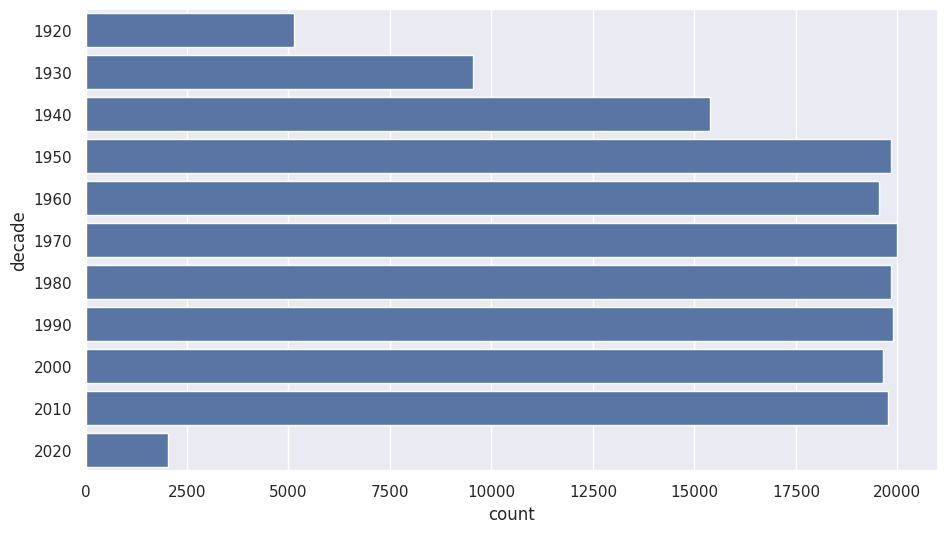

In [ ]:
def get_decade(year):
    period_start = int(year/10) * 10
    decade = '{}'.format(period_start)
    return decade

df['decade'] = df['year'].apply(get_decade)

sns.set(rc={'figure.figsize':(11 ,6)})
sns.countplot(df['decade'])

# Best to work with data from the 2000s to 2010s for more relevant data (> 35000 songs; enough for our analysis)

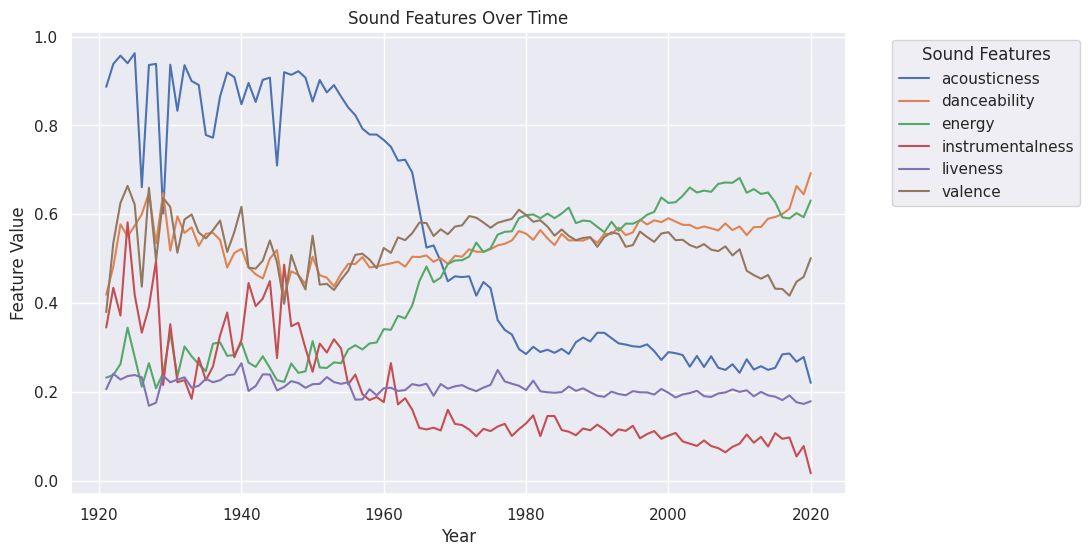

In [ ]:
sound_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'valence']
plt.figure(figsize=(10, 6))

for feature in sound_features:
    plt.plot(df_by_year['year'], df_by_year[feature], label=feature)

plt.xlabel('Year')
plt.ylabel('Feature Value')
plt.title('Sound Features Over Time')
plt.legend(title='Sound Features', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# acousticness and instrumentalness has gone down, danceability and energy has gone up

In [ ]:
df_rel = df[(df['decade'] == '2000') | (df['decade'] == '2010') | (df['decade'] == '2020')]
df_rel.reset_index(drop=True, inplace=True)
df_rel

,name,artists,release_date,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,decade
0,Yellow,['Coldplay'],2000-07-10,0.285,2000,0.00239,0.429,266773,0.661,0,0.000121,11,0.2340,-7.227,1,84,0.0281,173.372,2000
1,Ms. Jackson,['OutKast'],2000-10-31,0.613,2000,0.14300,0.843,270507,0.806,1,0.000000,4,0.0771,-5.946,0,80,0.2690,94.948,2000
2,In the End,['Linkin Park'],2000-10-24,0.400,2000,0.00958,0.556,216880,0.864,0,0.000000,3,0.2090,-5.870,0,84,0.0584,105.143,2000
3,Kryptonite,['3 Doors Down'],2000,0.543,2000,0.00664,0.545,233933,0.865,0,0.000011,11,0.1680,-5.708,0,78,0.0286,99.009,2000
4,The Real Slim Shady,['Eminem'],2000-05-23,0.760,2000,0.03020,0.949,284200,0.661,1,0.000000,5,0.0454,-4.244,0,80,0.0572,104.504,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41445,China,"['Anuel AA', 'Daddy Yankee', 'KAROL G', 'Ozuna...",2020-05-29,0.608,2020,0.08460,0.786,301714,0.808,0,0.000289,7,0.0822,-3.702,1,72,0.0881,105.029,2020
41446,Halloweenie III: Seven Days,['Ashnikko'],2020-10-23,0.734,2020,0.20600,0.717,150654,0.753,0,0.000000,7,0.1010,-6.020,1,68,0.0605,137.936,2020
41447,AYA,['MAMAMOO'],2020-11-03,0.637,2020,0.10100,0.634,211280,0.858,0,0.000009,4,0.2580,-2.226,0,76,0.0809,91.688,2020
41448,Darkness,['Eminem'],2020-01-17,0.195,2020,0.00998,0.671,337147,0.623,1,0.000008,2,0.6430,-7.161,1,70,0.3080,75.055,2020


# Mapping Genre Data to Song Data

### Analyzing genre data

In [ ]:
df_by_genres
# We have too many genres, need to select some which are relevant to the current age - df_rel based on sound features - thats the overall goal?

,mode,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,21st century classical,0.979333,0.162883,1.602977e+05,0.071317,0.606834,0.361600,-31.514333,0.040567,75.336500,0.103783,27.833333,6
1,1,432hz,0.494780,0.299333,1.048887e+06,0.450678,0.477762,0.131000,-16.854000,0.076817,120.285667,0.221750,52.500000,5
2,1,8-bit,0.762000,0.712000,1.151770e+05,0.818000,0.876000,0.126000,-9.180000,0.047000,133.444000,0.975000,48.000000,7
3,1,[],0.651417,0.529093,2.328809e+05,0.419146,0.205309,0.218696,-12.288965,0.107872,112.857352,0.513604,20.859882,7
4,1,a cappella,0.676557,0.538961,1.906285e+05,0.316434,0.003003,0.172254,-12.479387,0.082851,112.110362,0.448249,45.820071,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2968,1,zolo,0.222625,0.547082,2.580991e+05,0.610240,0.143872,0.204206,-11.295878,0.061088,125.494919,0.596155,33.778943,9
2969,0,zouglou,0.161000,0.863000,2.063200e+05,0.909000,0.000000,0.108000,-5.985000,0.081300,119.038000,0.845000,58.000000,7
2970,1,zouk,0.263261,0.748889,3.060728e+05,0.622444,0.257227,0.089678,-10.289222,0.038778,101.965222,0.824111,46.666667,5
2971,0,zurich indie,0.993000,0.705667,1.984173e+05,0.172667,0.468633,0.179667,-11.453333,0.348667,91.278000,0.739000,0.000000,7


In [ ]:
df_pop_gen = df_by_genres.sort_values('popularity', ascending=False).head(10)
df_pop_gen

,mode,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
237,1,basshall,0.213167,0.81800,169799.166667,0.630167,0.000020,0.081067,-6.627833,0.134833,115.092500,0.588667,80.666667,2
2778,0,turkish edm,0.008290,0.69800,186700.000000,0.719000,0.000004,0.326000,-4.923000,0.045500,120.062000,0.364000,80.000000,0
2533,1,south african house,0.043833,0.84700,311854.333333,0.562333,0.130339,0.075133,-7.719000,0.050733,123.676333,0.834333,80.000000,1
2755,1,trap venezolano,0.044600,0.87700,231848.000000,0.777000,0.000035,0.086300,-4.246000,0.117000,102.020000,0.706000,80.000000,1
46,0,alberta hip hop,0.330000,0.88500,144000.000000,0.685000,0.000000,0.148000,-6.429000,0.062700,99.954000,0.937000,78.500000,11
536,0,chinese electropop,0.002570,0.66000,217088.000000,0.787000,0.000000,0.323000,-4.592000,0.032000,142.018000,0.199000,78.500000,1
37,0,afroswing,0.318450,0.71175,179995.375000,0.580187,0.000258,0.189950,-7.016687,0.195563,83.250125,0.676625,77.312500,11
31,0,afro soul,0.006270,0.76600,202627.000000,0.873000,0.000000,0.076400,-6.381000,0.143000,126.988000,0.743000,77.000000,11
2383,1,russian dance,0.005610,0.65300,198095.000000,0.945000,0.915000,0.439000,-2.634000,0.096000,126.093000,0.326000,77.000000,5
1239,1,guaracha,0.009030,0.74500,189818.000000,0.972000,0.465000,0.297000,-3.506000,0.077400,128.031000,0.556000,77.000000,7


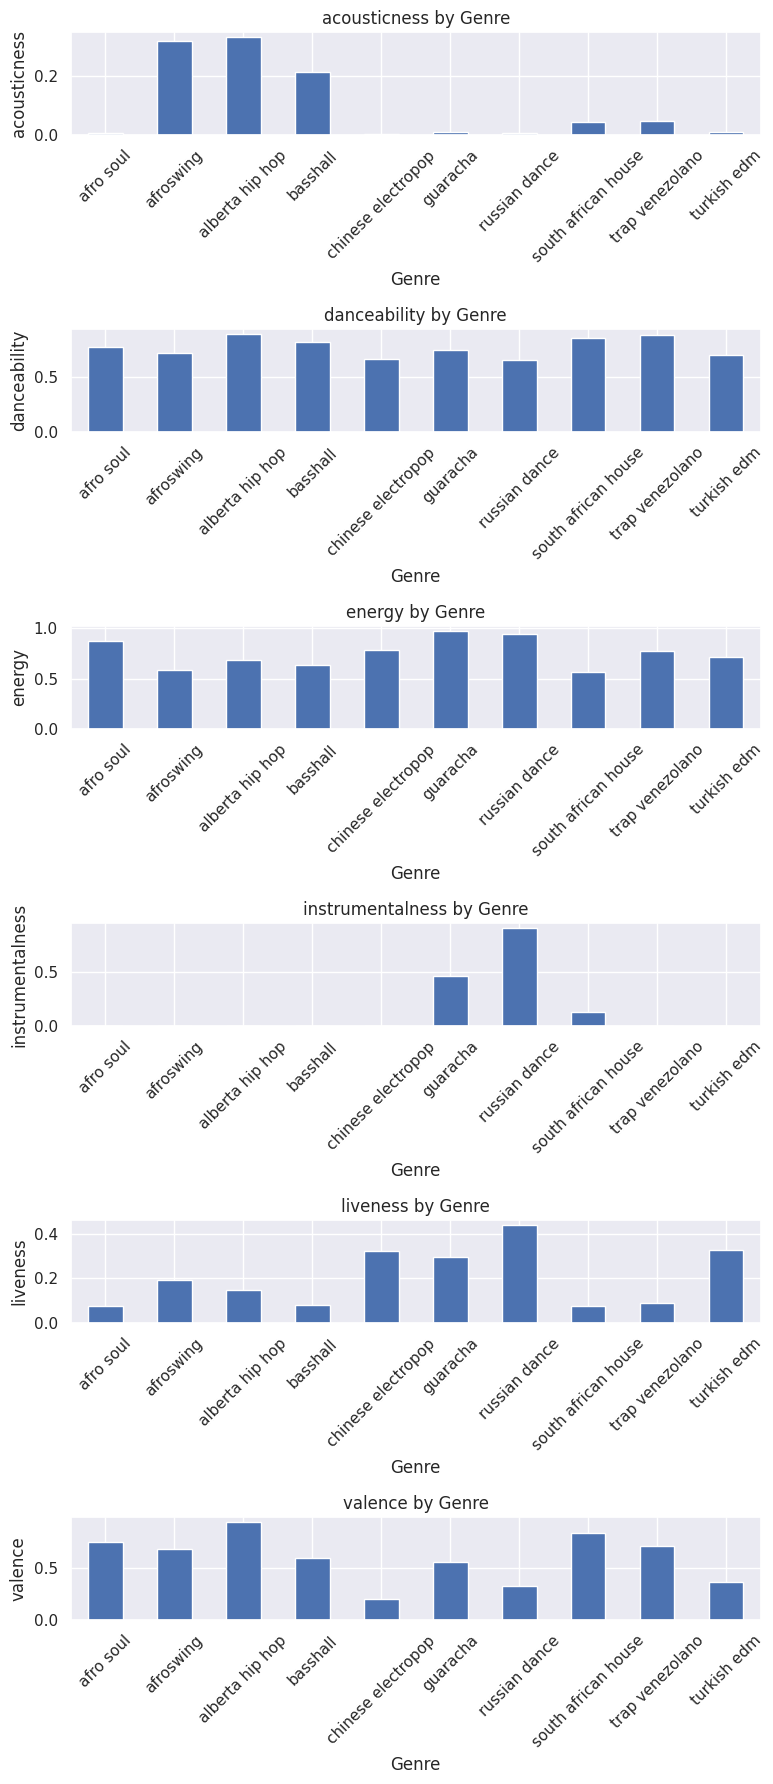

In [ ]:
top_genres = df_pop_gen['genres'].head(10)
fig, axes = plt.subplots(nrows=len(sound_features), ncols=1, figsize=(8, 18))

for i, feature in enumerate(sound_features):
    df_by_genres.loc[df_by_genres['genres'].isin(top_genres)].plot(x='genres', y=feature, kind='bar', ax=axes[i], legend=False)
    axes[i].set_title(f'{feature} by Genre')
    axes[i].set_xlabel('Genre')
    axes[i].set_ylabel(feature)
    axes[i].tick_params(axis='x', rotation=45)
    plt.tight_layout()


plt.show()

# Can be seen that values such as danceability and energy are not so good indicators across top genres
# Need to verify this through PCA on overall song data

### Principle Component Analysis

In [ ]:
# idea - apply PCA - find out relevant measures and apply similarity measures on those features to get most relevant genres - then apply clustering to cluster songs into those genres

In [ ]:
df_rel

,name,artists,release_date,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,decade
0,Yellow,['Coldplay'],2000-07-10,0.285,2000,0.00239,0.429,266773,0.661,0,0.000121,11,0.2340,-7.227,1,84,0.0281,173.372,2000
1,Ms. Jackson,['OutKast'],2000-10-31,0.613,2000,0.14300,0.843,270507,0.806,1,0.000000,4,0.0771,-5.946,0,80,0.2690,94.948,2000
2,In the End,['Linkin Park'],2000-10-24,0.400,2000,0.00958,0.556,216880,0.864,0,0.000000,3,0.2090,-5.870,0,84,0.0584,105.143,2000
3,Kryptonite,['3 Doors Down'],2000,0.543,2000,0.00664,0.545,233933,0.865,0,0.000011,11,0.1680,-5.708,0,78,0.0286,99.009,2000
4,The Real Slim Shady,['Eminem'],2000-05-23,0.760,2000,0.03020,0.949,284200,0.661,1,0.000000,5,0.0454,-4.244,0,80,0.0572,104.504,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41445,China,"['Anuel AA', 'Daddy Yankee', 'KAROL G', 'Ozuna...",2020-05-29,0.608,2020,0.08460,0.786,301714,0.808,0,0.000289,7,0.0822,-3.702,1,72,0.0881,105.029,2020
41446,Halloweenie III: Seven Days,['Ashnikko'],2020-10-23,0.734,2020,0.20600,0.717,150654,0.753,0,0.000000,7,0.1010,-6.020,1,68,0.0605,137.936,2020
41447,AYA,['MAMAMOO'],2020-11-03,0.637,2020,0.10100,0.634,211280,0.858,0,0.000009,4,0.2580,-2.226,0,76,0.0809,91.688,2020
41448,Darkness,['Eminem'],2020-01-17,0.195,2020,0.00998,0.671,337147,0.623,1,0.000008,2,0.6430,-7.161,1,70,0.3080,75.055,2020


In [ ]:
numeric_cols = df_rel.select_dtypes(include=np.number).columns
numeric_cols = numeric_cols.drop(['year', 'explicit'])
numeric_cols.dtype

dtype('O')

In [ ]:
scaler = StandardScaler()
scaler.fit(df_rel[numeric_cols])
scaled_features = scaler.transform(df_rel[numeric_cols])
scaled_features

array([[-0.82887918, -0.88066269, -0.92840963, ...,  2.2685235 ,
        -0.65036743,  1.69918426],
       [ 0.47446099, -0.40843856,  1.44327208, ...,  1.96381279,
         1.66861666, -0.85525068],
       [-0.3719154 , -0.85651582, -0.20086476, ...,  2.2685235 ,
        -0.35868948, -0.52317805],
       ...,
       [ 0.56982734, -0.54949121,  0.24597383, ...,  1.65910207,
        -0.14209694, -0.96143575],
       [-1.18650301, -0.85517246,  0.45793572, ...,  1.202036  ,
         2.04404372, -1.50320761],
       [ 0.58969533, -0.44538092,  1.51774518, ...,  1.50674671,
         0.11877673, -0.85385008]])

In [ ]:
pca = PCA(n_components=13)
principal_components = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(data=principal_components)
pca_df.set_index(df_rel.index, inplace=True)
pca_df

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.316369,-0.816050,0.519083,1.802526,2.310079,0.382262,-0.436024,1.450909,-0.208687,1.268537,0.445223,-0.573079,-0.032430
1,1.548192,1.620871,-1.515447,0.857949,0.024292,-1.746149,1.100888,-0.225072,0.160258,0.780783,-0.449058,0.156134,0.402586
2,0.992301,0.113986,-0.326152,1.717342,1.053413,-1.607044,-0.211309,-1.261439,-0.365277,0.516112,-0.288677,-0.193571,0.394514
3,1.150392,0.163266,-1.219450,0.539942,2.107151,-0.987686,-1.190484,-0.289988,-0.100652,0.639890,-0.503425,-0.336088,0.273362
4,1.688642,1.849543,-0.664041,-0.225595,0.995396,-1.918161,0.466771,-0.434718,-0.970253,1.023490,0.380656,-0.068432,-0.164935
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41445,1.428846,0.751084,0.315227,-0.170320,0.485744,-1.341268,-0.259533,0.942149,0.228709,1.096028,0.056176,0.271686,0.177564
41446,1.184255,1.213424,0.867741,0.030253,0.756428,0.511871,-0.262655,0.201253,0.074115,0.807456,-0.054190,-0.044247,0.249065
41447,1.649740,0.498388,-0.672680,0.949437,0.452730,-1.350158,-0.645896,-1.158384,-0.560124,0.367472,-0.594932,0.326615,-0.120305
41448,0.394845,-0.635128,-1.209276,2.521413,-2.756805,-1.587265,-0.728261,0.959965,0.212659,0.640958,0.753400,-0.186233,-0.193327


In [ ]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.23757044, 0.11480373, 0.09188518, 0.08187158, 0.08156182,
       0.07435206, 0.07059867, 0.06520424, 0.0566332 , 0.05222379,
       0.03628728, 0.02513711, 0.01187091])

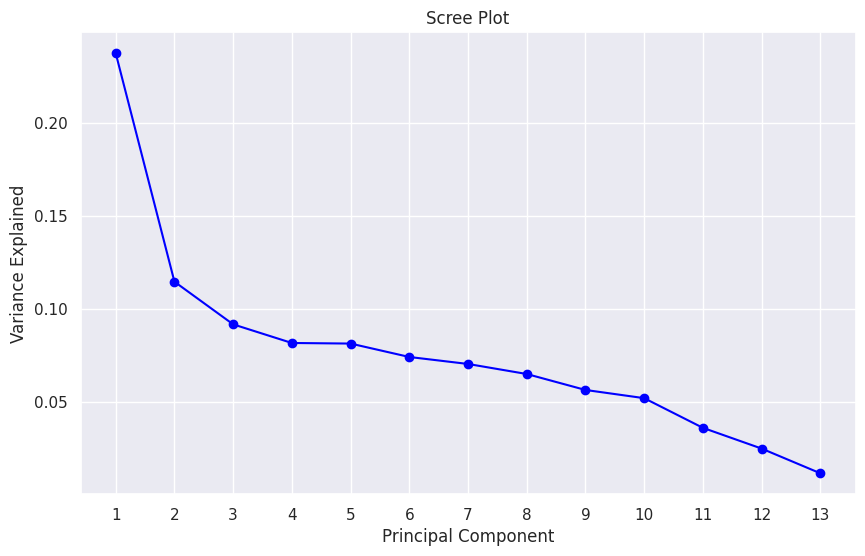

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'o-', color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)
plt.show()

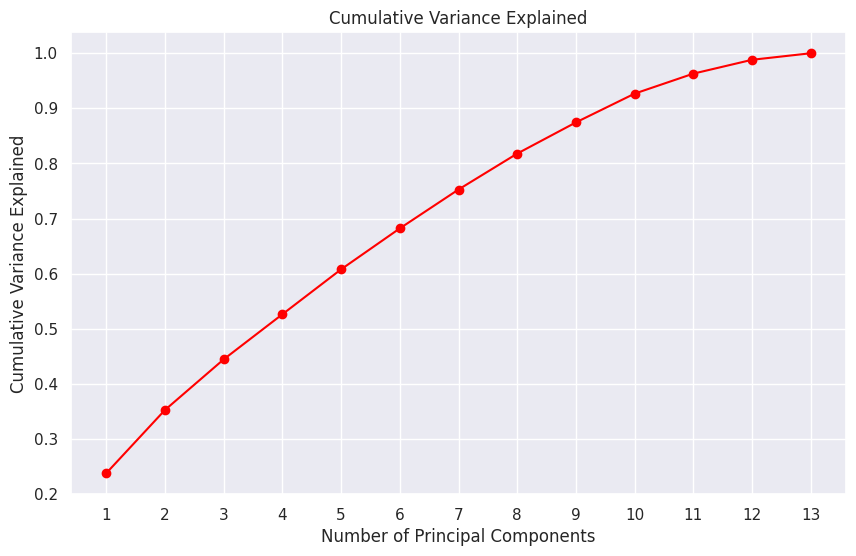

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), 'o-', color='red')
plt.title('Cumulative Variance Explained')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)
plt.show()

In [ ]:
# Dimensionality reduction is mostly not efficient in this case since from the cumulative explained variance we see a gradual increase
# need to cluster with complete dataset

In [ ]:
weights = pca.components_
weights_df = pd.DataFrame(weights, columns=numeric_cols)
weights_df

,valence,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
0,0.324746,-0.421118,0.277158,-0.074838,0.465885,-0.343158,0.041942,0.072647,0.493528,-0.060226,0.049188,0.146239,0.148110
1,0.312919,0.284029,0.493031,-0.405558,-0.311396,-0.202511,0.023212,-0.294276,-0.107050,0.008528,0.336191,0.116809,-0.224802
2,0.034600,-0.006616,-0.124294,-0.151737,0.022362,-0.134457,-0.456172,-0.244549,0.118942,0.641818,0.050686,-0.445464,0.216159
3,-0.379385,0.008981,-0.262094,-0.220788,-0.035486,-0.212328,-0.194980,0.368410,0.021164,-0.017631,0.637491,0.301035,0.143821
4,-0.163452,-0.067390,-0.200248,-0.065541,0.020764,-0.048239,0.494642,-0.474377,0.095603,-0.305392,0.328112,-0.407787,0.274832
5,0.217169,0.191348,-0.109043,-0.514131,-0.030486,0.114200,0.300772,0.235364,-0.121691,0.118318,-0.293936,0.136470,0.588507
6,-0.051094,-0.009078,0.120587,0.242046,-0.079912,0.086911,-0.401244,-0.471553,-0.075467,-0.219636,-0.051070,0.434611,0.530519
7,-0.042129,0.154276,0.044446,0.518447,-0.160156,-0.358068,0.457210,-0.014437,0.020829,0.506592,0.055641,0.250980,0.131886
8,-0.346916,-0.299951,-0.113753,-0.356994,0.155936,0.188774,0.183930,-0.399933,0.026074,0.323974,-0.139513,0.426047,-0.298240
9,0.264026,-0.184687,0.172183,0.170014,0.150956,0.678178,0.099841,0.085722,-0.142912,0.253372,0.493074,0.002044,0.099265


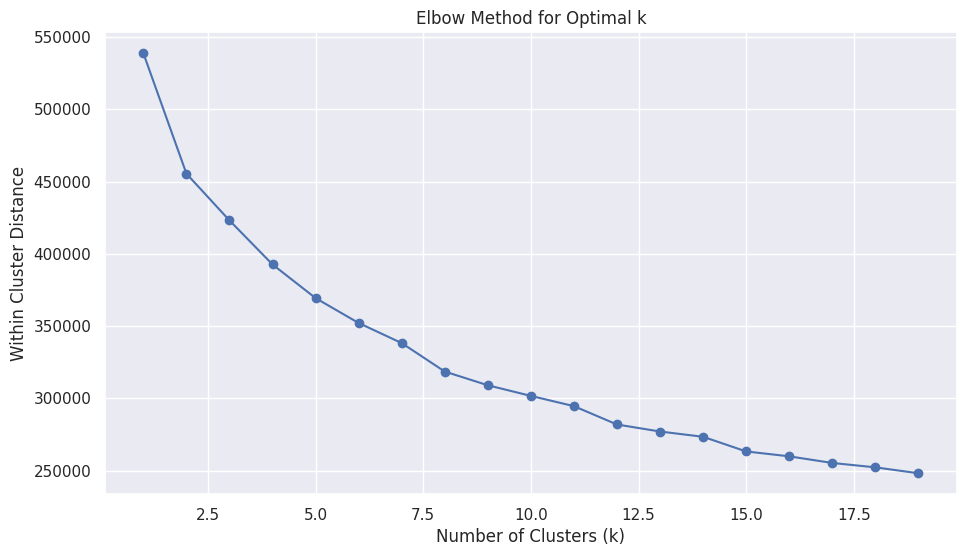

In [ ]:
scaler = StandardScaler()
scaler.fit(df_rel[numeric_cols])
scaled_features = scaler.transform(df_rel[numeric_cols])

within_cluster_distance = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_features)
    within_cluster_distance.append(kmeans.inertia_)


plt.plot(range(1, 20), within_cluster_distance, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within Cluster Distance')
plt.title('Elbow Method for Optimal k')
plt.show()

In [ ]:
optimal_k = 10
# since we have a large number of possible "genres" we go with a higher number of possible cluster
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
kmeans.fit(scaled_features)
df_rel['cluster'] = kmeans.labels_

<ipython-input-70-e0504b51890b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rel['cluster'] = kmeans.labels_


In [ ]:
# We have now made all the clusters of all the music, need to do the similarith measures of the centroids with the genre average to find out the best genre fits

### Similarity Measures

In [ ]:
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=numeric_cols)
cluster_centers['cluster_label'] = range(optimal_k)
cluster_centers = cluster_centers.set_index('cluster_label')
cluster_centers

,valence,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
cluster_label,,,,,,,,,,,,,
0,-1.411834,1.919731,-1.753609,0.115099,-2.097051,3.142237,-0.187380,-0.207238,-3.262618,0.058493,-0.170990,-0.465032,-0.739556
1,1.326317,0.071721,0.720614,-0.270119,0.188665,-0.300290,0.208316,-0.268256,0.218828,0.683820,-0.337687,-0.273732,0.112437
2,-0.250390,-0.671526,-0.982770,0.067262,0.808682,-0.275979,-0.039811,-0.022078,0.553613,0.019626,-0.245989,-0.088424,1.292795
3,-0.014055,-0.452782,0.255589,-0.041921,0.278474,-0.293551,-1.114410,-0.145513,0.337987,0.711964,0.224252,-0.237125,-0.216098
4,-0.271498,-0.422941,-0.033960,0.021780,0.241085,-0.298012,0.814750,-0.200015,0.329955,0.708650,0.283949,-0.334606,-0.329258
5,0.286181,-0.329402,0.468981,-0.040298,0.267154,-0.293730,0.243228,-0.189113,0.307823,-1.401464,0.270610,-0.134967,-0.166533
6,-0.684020,1.525707,-0.458264,-0.045488,-1.369479,-0.230440,-0.084328,-0.294777,-0.767803,0.270380,0.008561,-0.466563,-0.235510
7,-0.386393,-0.239204,-0.121932,0.806285,0.224907,2.933023,0.015006,-0.104749,-0.278161,-0.197833,-1.043766,-0.353137,0.042470
8,0.199632,-0.187526,0.672701,-0.107810,0.040270,-0.326349,0.032242,0.041026,0.100382,-0.205846,0.151149,2.543812,-0.000615


In [ ]:
genre_data = df_by_genres.copy()

In [ ]:
genre_scaled_features = scaler.transform(genre_data[numeric_cols])
genre_data[numeric_cols] = genre_scaled_features

In [ ]:
genre_data

,mode,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,0.713539,21st century classical,2.400300,-2.452912,-0.770665,-2.483633,2.239479,1.066382,-5.267566,-0.530359,-1.494039,-1.548961,-2.010123,0.213143
1,0.713539,432hz,0.772978,-1.671231,8.867916,-0.826306,1.688465,-0.382452,-2.057016,-0.181404,-0.029949,-1.080209,-0.131073,-0.066775
2,0.713539,8-bit,1.670409,0.692812,-1.260091,0.778421,3.388560,-0.413867,-0.376443,-0.468430,0.398645,1.912903,-0.473873,0.493062
3,0.713539,[],1.299027,-0.355009,0.016649,-0.964062,0.525355,0.168531,-1.057293,0.117540,-0.271905,0.079502,-2.541344,0.493062
4,0.713539,a cappella,1.383458,-0.298475,-0.441664,-1.412784,-0.338296,-0.123257,-1.098995,-0.123312,-0.296236,-0.180195,-0.639935,0.493062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2968,0.713539,zolo,-0.141026,-0.251956,0.290192,-0.129227,0.263076,0.077495,-0.839811,-0.332815,0.139727,0.407527,-1.557200,1.052898
2969,-1.401464,zouglou,-0.347987,1.557846,-0.271458,1.175975,-0.351118,-0.526959,0.323248,-0.138246,-0.070589,1.396336,0.287904,0.493062
2970,0.713539,zouk,-0.004554,0.904138,0.810566,-0.075907,0.746994,-0.642075,-0.619358,-0.547580,-0.626685,1.313332,-0.575443,-0.066775
2971,-1.401464,zurich indie,2.446198,0.656531,-0.357179,-2.040862,1.649496,-0.076685,-0.874293,2.435515,-0.974790,0.975134,-4.130402,0.493062


In [ ]:
# prompt: map the cluster centers to the closest genre in genre data using similarity measures and put it in cluster centres

# Calculate cosine similarity between cluster centers and genre data
similarities = cosine_similarity(cluster_centers[numeric_cols], genre_data[numeric_cols])

# Find the closest genre for each cluster center
closest_genres = []
for i in range(optimal_k):
    closest_genre_index = np.argmax(similarities[i])
    closest_genres.append(genre_data.iloc[closest_genre_index]['genres'])

# Add the closest genre to the cluster_centers DataFrame
cluster_centers['closest_genre'] = closest_genres

In [ ]:
cluster_centers

,valence,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,closest_genre
cluster_label,,,,,,,,,,,,,,
0,-1.411834,1.919731,-1.753609,0.115099,-2.097051,3.142237,-0.187380,-0.207238,-3.262618,0.058493,-0.170990,-0.465032,-0.739556,experimental ambient
1,1.326317,0.071721,0.720614,-0.270119,0.188665,-0.300290,0.208316,-0.268256,0.218828,0.683820,-0.337687,-0.273732,0.112437,norteno
2,-0.250390,-0.671526,-0.982770,0.067262,0.808682,-0.275979,-0.039811,-0.022078,0.553613,0.019626,-0.245989,-0.088424,1.292795,norwegian punk rock
3,-0.014055,-0.452782,0.255589,-0.041921,0.278474,-0.293551,-1.114410,-0.145513,0.337987,0.711964,0.224252,-0.237125,-0.216098,swedish pop
4,-0.271498,-0.422941,-0.033960,0.021780,0.241085,-0.298012,0.814750,-0.200015,0.329955,0.708650,0.283949,-0.334606,-0.329258,indie poptimism
5,0.286181,-0.329402,0.468981,-0.040298,0.267154,-0.293730,0.243228,-0.189113,0.307823,-1.401464,0.270610,-0.134967,-0.166533,k-pop boy group
6,-0.684020,1.525707,-0.458264,-0.045488,-1.369479,-0.230440,-0.084328,-0.294777,-0.767803,0.270380,0.008561,-0.466563,-0.235510,icelandic indie
7,-0.386393,-0.239204,-0.121932,0.806285,0.224907,2.933023,0.015006,-0.104749,-0.278161,-0.197833,-1.043766,-0.353137,0.042470,malmo indie
8,0.199632,-0.187526,0.672701,-0.107810,0.040270,-0.326349,0.032242,0.041026,0.100382,-0.205846,0.151149,2.543812,-0.000615,seattle hip hop


In [ ]:
cluster_genre_map = dict(zip(cluster_centers.index, cluster_centers['closest_genre']))
df_rel['mapped_genre'] = df_rel['cluster'].map(cluster_genre_map)

<ipython-input-78-98887cb832cd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rel['mapped_genre'] = df_rel['cluster'].map(cluster_genre_map)


In [ ]:
df_rel[df_rel['artists'] == "['Eminem']"]

,name,artists,release_date,valence,year,acousticness,danceability,duration_ms,energy,explicit,...,key,liveness,loudness,mode,popularity,speechiness,tempo,decade,cluster,mapped_genre
4,The Real Slim Shady,['Eminem'],2000-05-23,0.760,2000,0.03020,0.949,284200,0.661,1,...,5,0.0454,-4.244,0,80,0.0572,104.504,2000,5,k-pop boy group
31,The Way I Am,['Eminem'],2000-05-23,0.315,2000,0.14400,0.785,290427,0.871,1,...,4,0.3090,-2.692,0,71,0.2650,87.248,2000,8,seattle hip hop
48,Kill You,['Eminem'],2000-05-23,0.677,2000,0.15500,0.897,264400,0.559,1,...,11,0.2960,-8.268,1,69,0.3790,106.991,2000,8,seattle hip hop
166,Criminal,['Eminem'],2000-05-23,0.573,2000,0.12700,0.810,319600,0.724,1,...,4,0.3060,-6.153,0,60,0.2680,101.941,2000,8,seattle hip hop
171,Marshall Mathers,['Eminem'],2000-05-23,0.268,2000,0.03610,0.729,321267,0.759,1,...,11,0.0694,-3.177,0,59,0.1270,95.935,2000,5,k-pop boy group
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39382,Not Afraid,['Eminem'],2010-06-18,0.650,2010,0.53700,0.852,248133,0.955,0,...,0,0.3560,-1.206,0,41,0.2750,114.640,2010,8,seattle hip hop
39853,So Much Better,['Eminem'],2013-11-05,0.616,2013,0.25200,0.719,261387,0.858,1,...,10,0.6280,-1.366,0,53,0.2500,84.497,2010,9,puerto rican rock
39968,Evil Twin,['Eminem'],2013-11-05,0.783,2013,0.05290,0.648,356847,0.910,1,...,4,0.0834,-4.762,0,51,0.3630,83.091,2010,8,seattle hip hop
40715,Believe,['Eminem'],2017-12-15,0.110,2017,0.16000,0.884,315347,0.492,1,...,1,0.3590,-5.343,0,61,0.1120,130.072,2010,5,k-pop boy group


### Kernel Density estimation

### Understanding similarities of distributions of various parameter within same genre of music

In [ ]:
df_rel_shh = df_rel[df_rel['mapped_genre'] == 'seattle hip hop']
df_rel_shh

,name,artists,release_date,valence,year,acousticness,danceability,duration_ms,energy,explicit,...,key,liveness,loudness,mode,popularity,speechiness,tempo,decade,cluster,mapped_genre
1,Ms. Jackson,['OutKast'],2000-10-31,0.613,2000,0.14300,0.843,270507,0.806,1,...,4,0.0771,-5.946,0,80,0.269,94.948,2000,8,seattle hip hop
22,"So Fresh, So Clean",['OutKast'],2000-10-31,0.915,2000,0.02810,0.725,240027,0.640,1,...,5,0.0990,-7.905,0,68,0.332,166.028,2000,8,seattle hip hop
31,The Way I Am,['Eminem'],2000-05-23,0.315,2000,0.14400,0.785,290427,0.871,1,...,4,0.3090,-2.692,0,71,0.265,87.248,2000,8,seattle hip hop
48,Kill You,['Eminem'],2000-05-23,0.677,2000,0.15500,0.897,264400,0.559,1,...,11,0.2960,-8.268,1,69,0.379,106.991,2000,8,seattle hip hop
136,Batter Up,"['Nelly', 'Murphy Lee', 'Ali']",2000-06-27,0.581,2000,0.12800,0.840,327933,0.591,1,...,8,0.2510,-6.422,1,57,0.258,159.711,2000,8,seattle hip hop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41426,Tattoo - Remix with Camilo,"['Rauw Alejandro', 'Camilo']",2020-11-13,0.691,2020,0.04060,0.721,222680,0.637,0,...,9,0.0525,-5.134,1,71,0.286,193.922,2020,8,seattle hip hop
41431,Trials & Tribulations,['Polo G'],2020-05-15,0.545,2020,0.08290,0.796,176543,0.612,1,...,1,0.0607,-6.994,1,65,0.433,87.542,2020,8,seattle hip hop
41434,Address It,['LPB Poody'],2020-05-05,0.329,2020,0.10900,0.903,146688,0.611,1,...,10,0.0904,-8.006,0,68,0.268,94.525,2020,8,seattle hip hop
41436,7.62 God,['Pooh Shiesty'],2020-07-03,0.522,2020,0.00861,0.819,177110,0.651,1,...,10,0.3780,-5.859,0,62,0.291,77.013,2020,8,seattle hip hop


In [ ]:
cluster_8_df = df_rel[df_rel['cluster'] == 8]
artist_counts = cluster_8_df['artists'].value_counts()
artist_with_max_songs = artist_counts.index[0]
# Eminem has the most songs which come under the genre of Seattle Hip Hop

In [ ]:
param_cols = ['valence', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'popularity', 'speechiness']

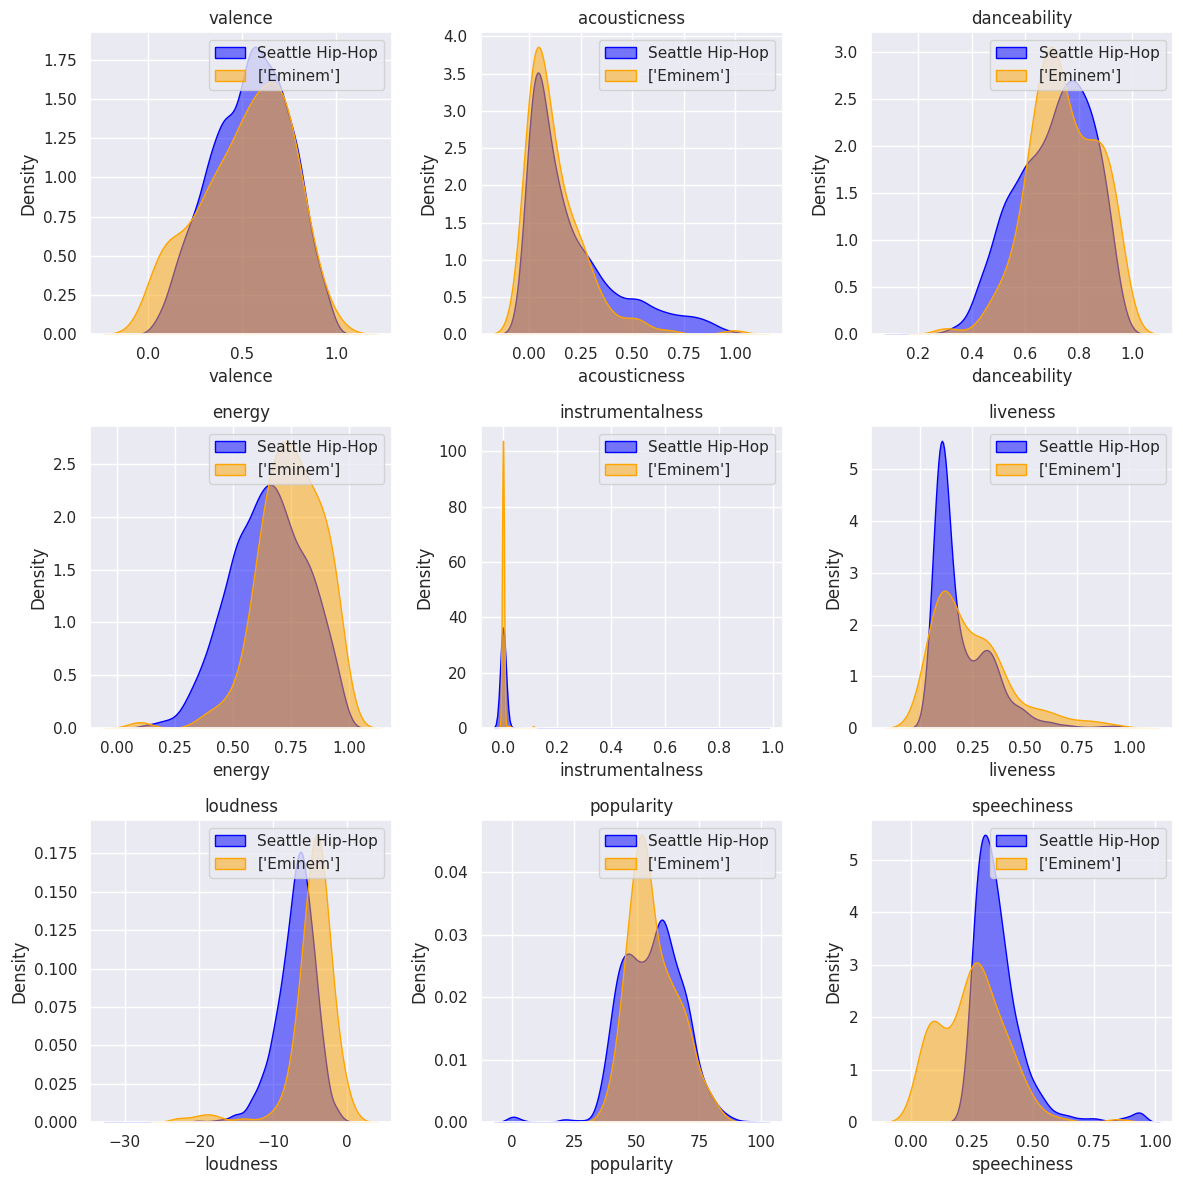

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
axes = axes.flatten()

artist = artist_with_max_songs

for i, col in enumerate(param_cols):
    sns.kdeplot(data=df_rel_shh, x=col, ax=axes[i], fill=True, label='Seattle Hip-Hop', color='blue', alpha=0.5)
    sns.kdeplot(data=df_rel[df_rel['artists'] == artist], x=col, ax=axes[i], fill=True, label=artist_with_max_songs, color='orange', alpha=0.5)

    axes[i].set_title(f'{col}')
    axes[i].legend()

plt.tight_layout()
plt.show()


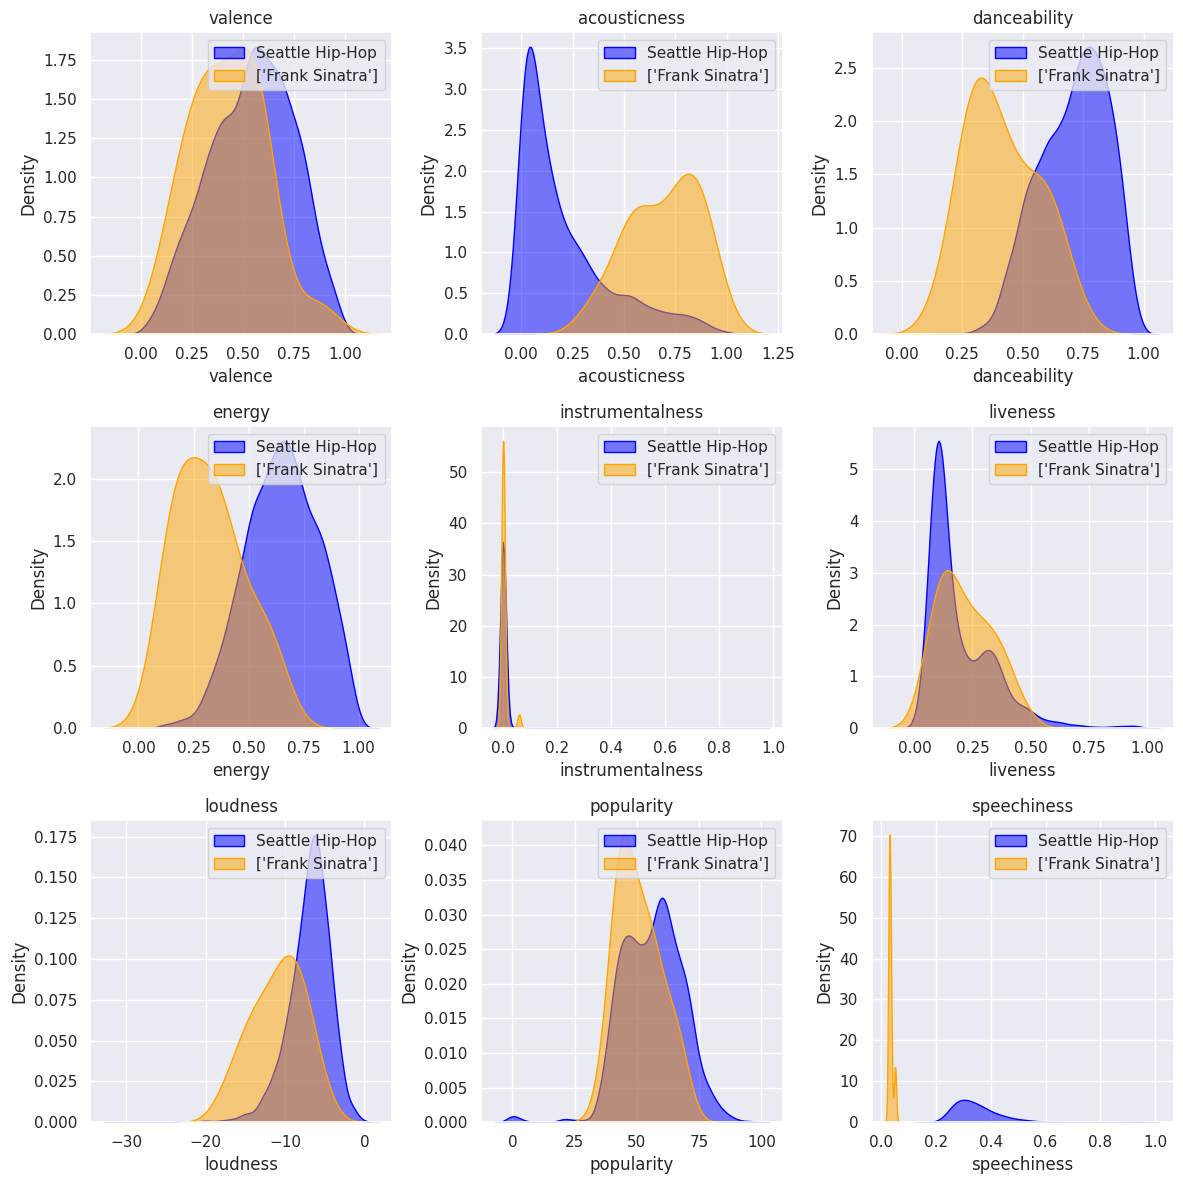

<Figure size 1100x600 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
axes = axes.flatten()

artist = "['Frank Sinatra']"

for i, col in enumerate(param_cols):
    sns.kdeplot(data=df_rel_shh, x=col, ax=axes[i], fill=True, label='Seattle Hip-Hop', color='blue', alpha=0.5)
    sns.kdeplot(data=df_rel[df_rel['artists'] == artist], x=col, ax=axes[i], fill=True, label="['Frank Sinatra']", color='orange', alpha=0.5)

    axes[i].set_title(f'{col}')
    axes[i].legend()

plt.tight_layout()
plt.show()
plt.savefig("KDE comparision: Frank Sinatra and Seattle Hip-Hop.png", transparent=True, dpi=300)


In [ ]:
df_rel.head(3)

,name,artists,release_date,valence,year,acousticness,danceability,duration_ms,energy,explicit,...,key,liveness,loudness,mode,popularity,speechiness,tempo,decade,cluster,mapped_genre
0,Yellow,['Coldplay'],2000-07-10,0.285,2000,0.00239,0.429,266773,0.661,0,...,11,0.2340,-7.227,1,84,0.0281,173.372,2000,4,indie poptimism
1,Ms. Jackson,['OutKast'],2000-10-31,0.613,2000,0.14300,0.843,270507,0.806,1,...,4,0.0771,-5.946,0,80,0.2690,94.948,2000,8,seattle hip hop
2,In the End,['Linkin Park'],2000-10-24,0.400,2000,0.00958,0.556,216880,0.864,0,...,3,0.2090,-5.870,0,84,0.0584,105.143,2000,5,k-pop boy group


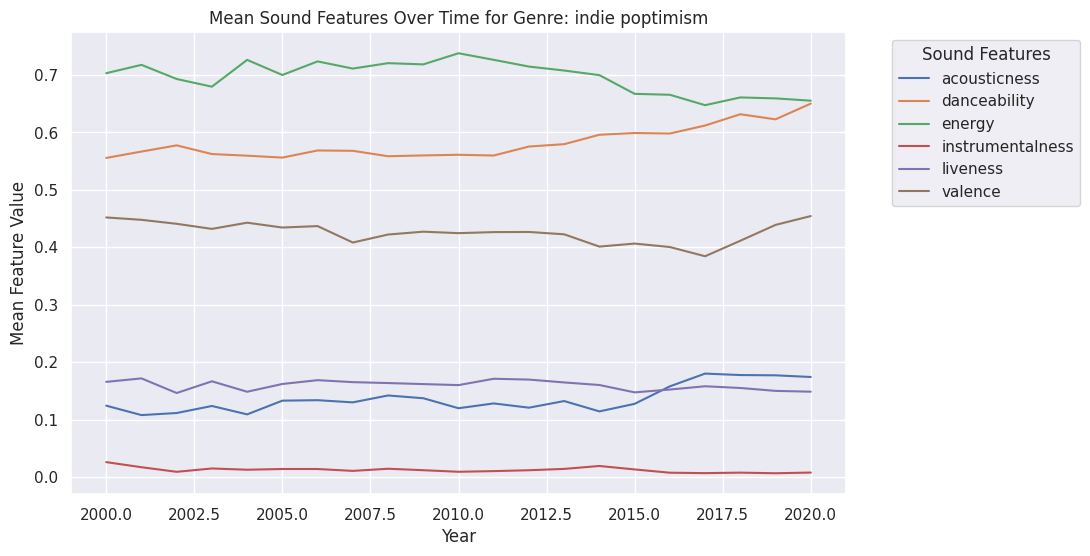

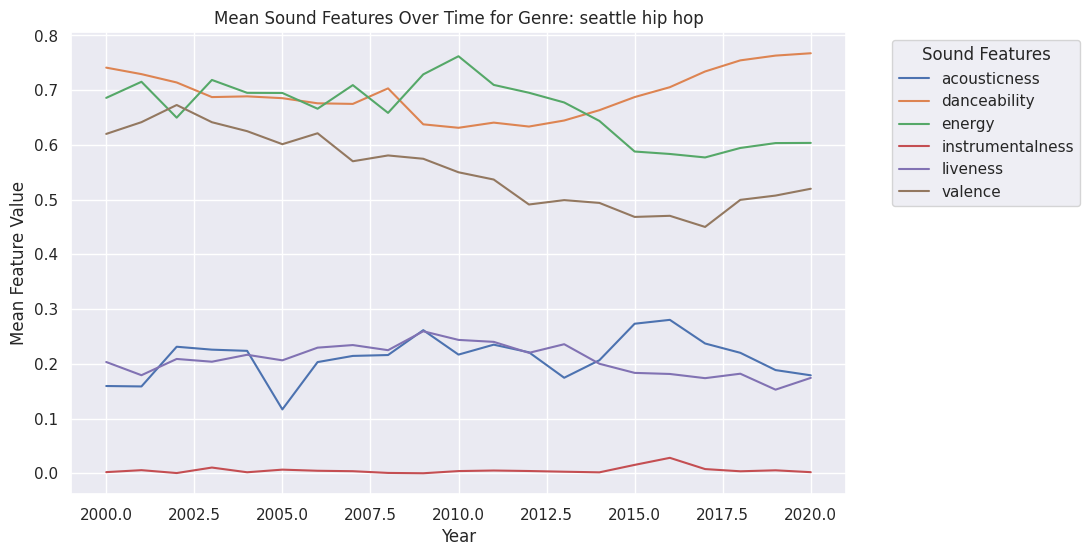

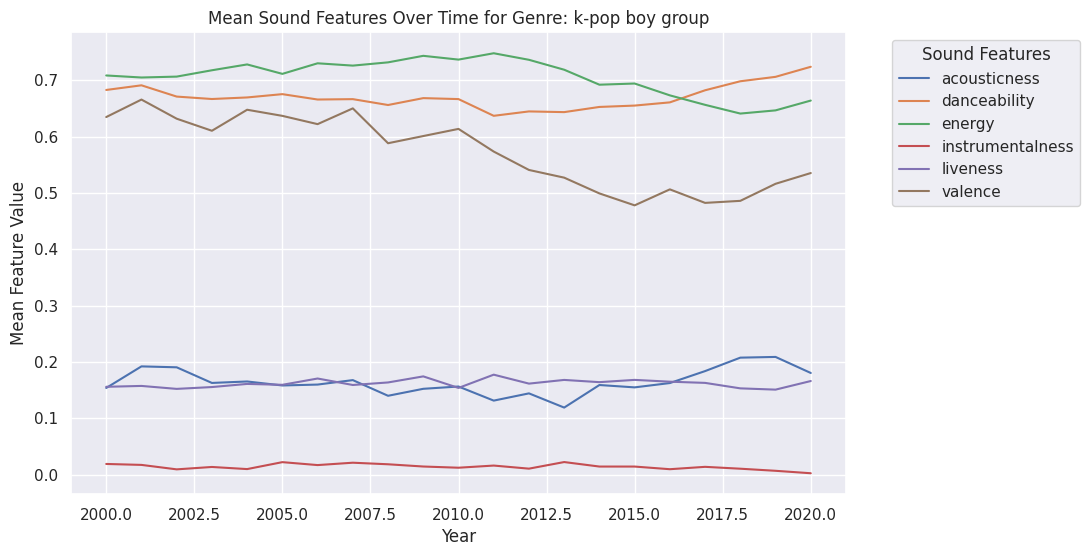

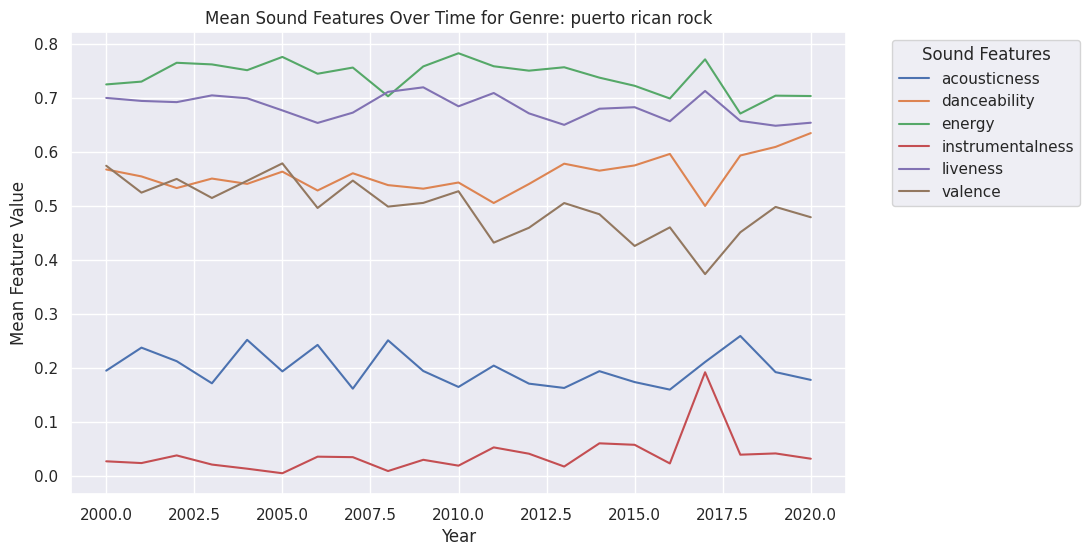

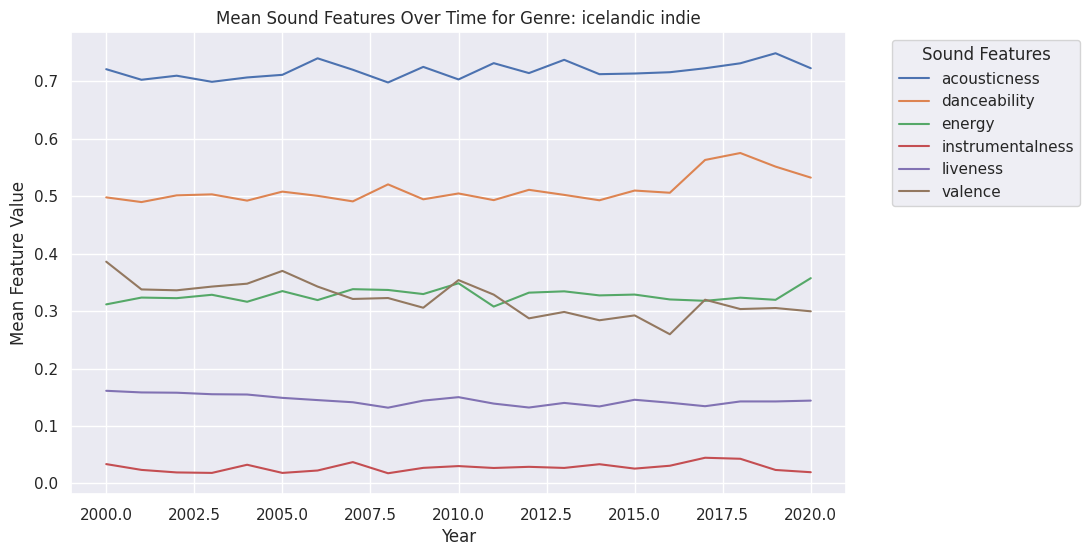

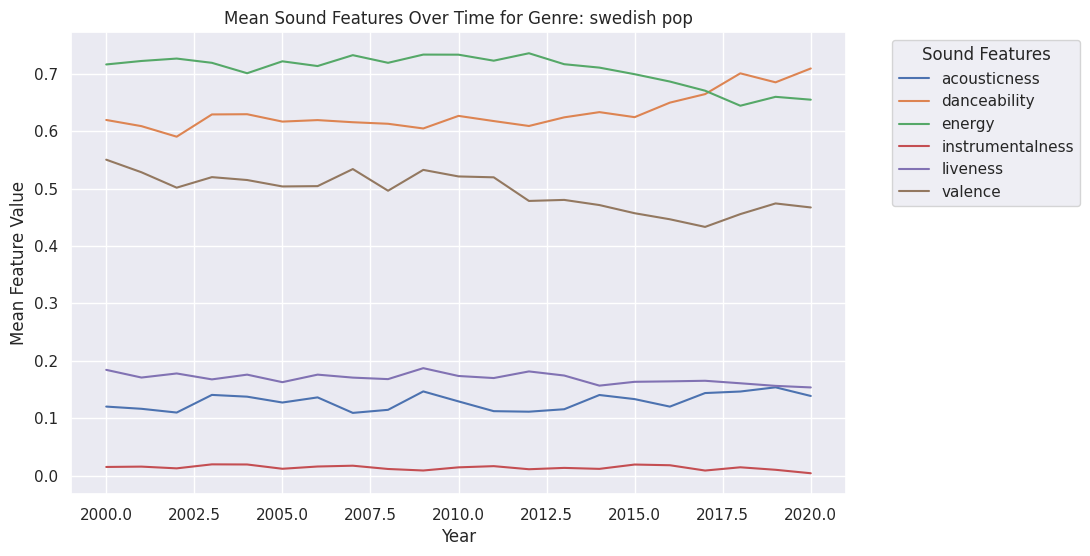

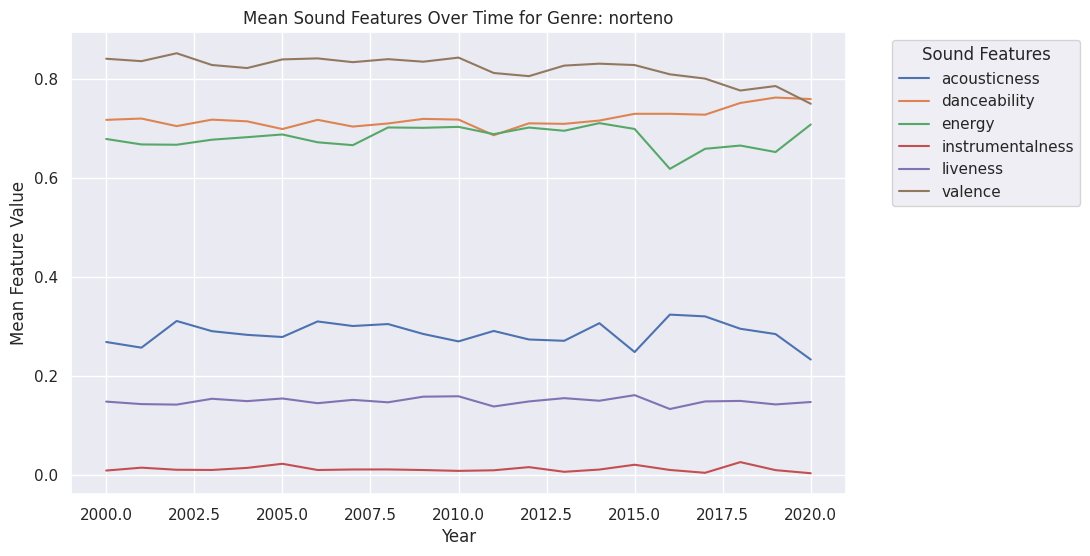

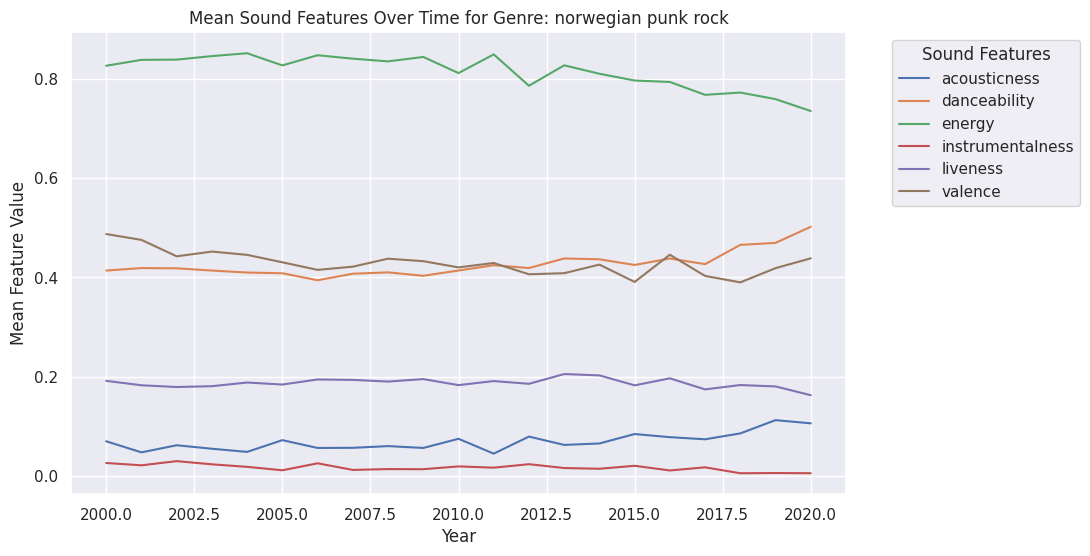

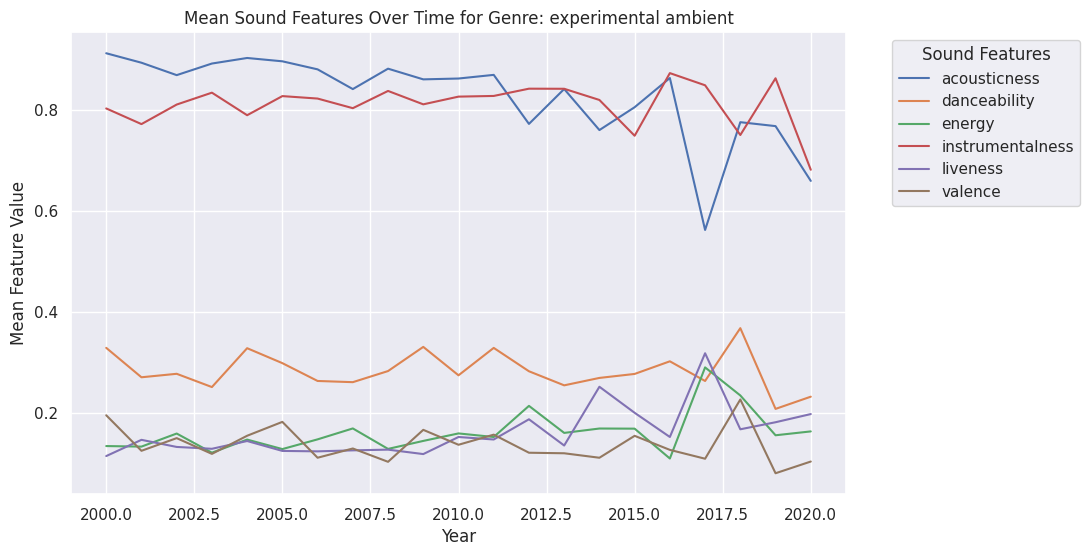

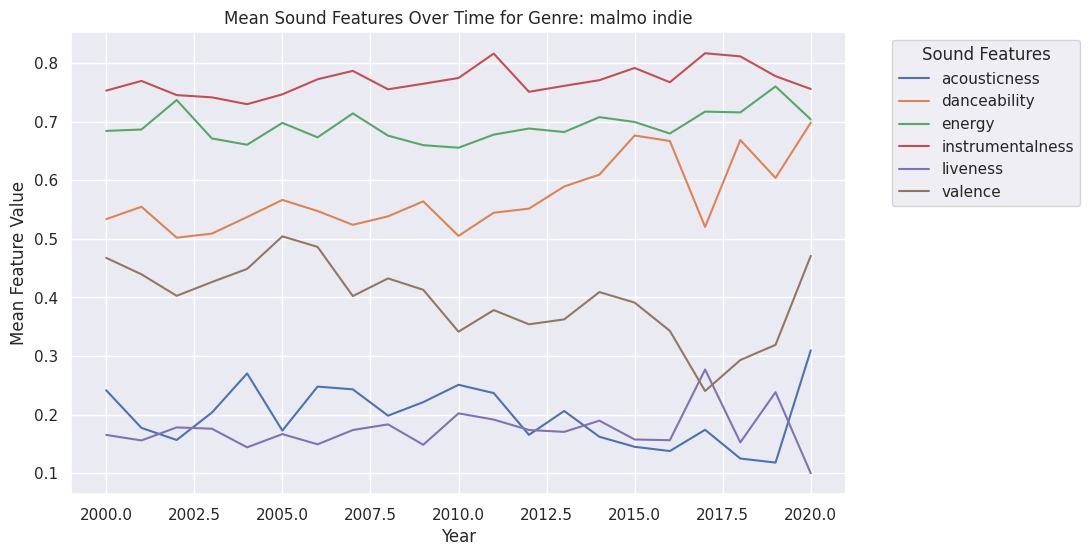

In [ ]:
import matplotlib.pyplot as plt

sound_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'valence']

# Group by genre and year, then calculate the mean for each feature
df_genre_year_mean = df_rel.groupby(['mapped_genre', 'year'])[sound_features].mean().reset_index()

for genre in df_rel['mapped_genre'].unique():
    plt.figure(figsize=(10, 6))
    for feature in sound_features:
        plt.plot(
            df_genre_year_mean[df_genre_year_mean['mapped_genre'] == genre]['year'],
            df_genre_year_mean[df_genre_year_mean['mapped_genre'] == genre][feature],
            label=feature
        )

    plt.xlabel('Year')
    plt.ylabel('Mean Feature Value')
    plt.title(f'Mean Sound Features Over Time for Genre: {genre}')
    plt.legend(title='Sound Features', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

